In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import hydroeval as he

from CompressedSensingInterpolator import CompresedSensingInterpolator
from InterpolateHelperFunctions import *

site_names_list = ['BEN', 'BLI', 'BSL', 'CLE', 'CRB', 'DAI', 'DFF', 'DFL', 'DFM', 'DFU', 'HCL', 'HCN', 'HCS', 'IND', 'LAK', 'LDF', 'MIT', 'NEB', 'PBC', 'SBL', 'SFL', 'SHE', 'SOL', 'STR', 'TCU', 'TIE', 'WAN']
all_pressure_df = pd.read_csv("all_pressure.csv")

0.20703391759617573
0.4274214038325243


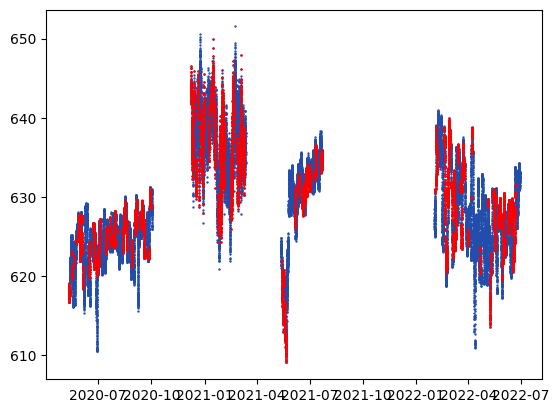

In [16]:
site_names_list = ['BEN', 'BLI', 'BSL', 'CLE', 'CRB', 'DAI', 'DFF', 'DFL', 'DFM', 'DFU', 'HCL', 'HCN', 'HCS', 'IND', 'LAK', 'LDF', 'MIT', 'NEB', 'PBC', 'SBL', 'SFL', 'SHE', 'SOL', 'STR', 'TCU', 'TIE', 'WAN']
all_pressure_df = pd.read_csv("all_pressure.csv")
site_id = "BEN"
site_df = pd.DataFrame()
site_df[["datetime","pressure_hobo"]] = all_pressure_df[["datetime",site_id]]
site_df['datetime'] = pd.to_datetime(site_df['datetime'], format='%Y-%m-%d %H:%M:%S')
site_df = site_df[site_df['pressure_hobo'].notna()]
all_days = pd.date_range(site_df['datetime'].min(), site_df['datetime'].max(), freq='15min')
all_days = pd.DataFrame(all_days, columns=["datetime"])
site_df = all_days.merge(site_df, on='datetime', how='left')

#generating a test dataframe from our actual data. This function generate randomly indexed sequences of nas of random lengths
test_df = get_test_df(site_df)

In [43]:
down_sample_list = [10,15,20,30,40,50]
mv_avg_width_list = [5,10,15,20,30,40,50,75,100,150,200]

Working on site: BEN
0.20703391759617573
0.43095518237244623


creating design matrix: 100%|██████████| 3741/3741 [00:00<00:00, 6706.61it/s]


NAs per column:
datetime             0.000000
index                0.899988
pressure_filled      0.899988
pressure_hobo        0.860219
pressure_combined    0.774173
dtype: float64


creating design matrix: 100%|██████████| 2494/2494 [00:00<00:00, 10136.22it/s]


NAs per column:
datetime             0.000000
index                0.933330
pressure_filled      0.933330
pressure_hobo        0.860219
pressure_combined    0.802895
dtype: float64


creating design matrix: 100%|██████████| 1871/1871 [00:00<00:00, 10569.52it/s]


NAs per column:
datetime             0.000000
index                0.949987
pressure_filled      0.949987
pressure_hobo        0.860219
pressure_combined    0.817169
dtype: float64


creating design matrix: 100%|██████████| 1248/1248 [00:00<00:00, 16521.50it/s]


NAs per column:
datetime             0.000000
index                0.966658
pressure_filled      0.966658
pressure_hobo        0.860219
pressure_combined    0.831617
dtype: float64


creating design matrix: 100%|██████████| 936/936 [00:00<00:00, 17333.44it/s]


NAs per column:
datetime             0.000000
index                0.974987
pressure_filled      0.974987
pressure_hobo        0.860219
pressure_combined    0.838714
dtype: float64


creating design matrix: 100%|██████████| 749/749 [00:00<00:00, 22664.39it/s]


NAs per column:
datetime             0.000000
index                0.979995
pressure_filled      0.979995
pressure_hobo        0.860219
pressure_combined    0.843093
dtype: float64
Working on site: BLI
0.22022796180099552
0.44493944147086884


creating design matrix: 100%|██████████| 3093/3093 [00:00<00:00, 8139.69it/s]


NAs per column:
datetime             0.000000
index                0.887673
pressure_filled      0.887673
pressure_hobo        0.886927
pressure_combined    0.789192
dtype: float64


creating design matrix: 100%|██████████| 2062/2062 [00:00<00:00, 11564.88it/s]


NAs per column:
datetime             0.000000
index                0.925969
pressure_filled      0.925969
pressure_hobo        0.886927
pressure_combined    0.822559
dtype: float64


creating design matrix: 100%|██████████| 1547/1547 [00:00<00:00, 13381.98it/s]


NAs per column:
datetime             0.000000
index                0.943836
pressure_filled      0.943836
pressure_hobo        0.886927
pressure_combined    0.837946
dtype: float64


creating design matrix: 100%|██████████| 1032/1032 [00:00<00:00, 17781.97it/s]


NAs per column:
datetime             0.000000
index                0.962985
pressure_filled      0.962985
pressure_hobo        0.886927
pressure_combined    0.854597
dtype: float64


creating design matrix: 100%|██████████| 774/774 [00:00<00:00, 26648.86it/s]


NAs per column:
datetime             0.000000
index                0.971918
pressure_filled      0.971918
pressure_hobo        0.886927
pressure_combined    0.862542
dtype: float64


creating design matrix: 100%|██████████| 619/619 [00:00<00:00, 32511.95it/s]


NAs per column:
datetime             0.000000
index                0.977528
pressure_filled      0.977528
pressure_hobo        0.886927
pressure_combined    0.867309
dtype: float64
Working on site: BSL
0.2317669582259645
0.4309393266573021


creating design matrix: 100%|██████████| 5518/5518 [00:01<00:00, 4157.58it/s]


NAs per column:
datetime             0.000000
index                0.892135
pressure_filled      0.892135
pressure_hobo        0.860505
pressure_combined    0.768619
dtype: float64


creating design matrix: 100%|██████████| 3679/3679 [00:00<00:00, 6895.29it/s]


NAs per column:
datetime             0.000000
index                0.927485
pressure_filled      0.927485
pressure_hobo        0.860505
pressure_combined    0.798706
dtype: float64


creating design matrix: 100%|██████████| 2760/2760 [00:00<00:00, 8922.38it/s]


NAs per column:
datetime             0.000000
index                0.946068
pressure_filled      0.946068
pressure_hobo        0.860505
pressure_combined    0.814494
dtype: float64


creating design matrix: 100%|██████████| 1840/1840 [00:00<00:00, 12457.46it/s]


NAs per column:
datetime             0.000000
index                0.963734
pressure_filled      0.963734
pressure_hobo        0.860505
pressure_combined    0.829565
dtype: float64


creating design matrix: 100%|██████████| 1380/1380 [00:00<00:00, 16951.84it/s]


NAs per column:
datetime             0.000000
index                0.973025
pressure_filled      0.973025
pressure_hobo        0.860505
pressure_combined    0.837422
dtype: float64


creating design matrix: 100%|██████████| 1104/1104 [00:00<00:00, 17888.85it/s]


NAs per column:
datetime             0.000000
index                0.978432
pressure_filled      0.978432
pressure_hobo        0.860505
pressure_combined    0.842186
dtype: float64
Working on site: CLE
0.12274691732551736
0.42027050993643295


creating design matrix: 100%|██████████| 5358/5358 [00:01<00:00, 4598.93it/s]


NAs per column:
datetime             0.000000
index                0.879400
pressure_filled      0.879400
pressure_hobo        0.840541
pressure_combined    0.740038
dtype: float64


creating design matrix: 100%|██████████| 3572/3572 [00:00<00:00, 7066.83it/s]


NAs per column:
datetime             0.000000
index                0.915141
pressure_filled      0.915141
pressure_hobo        0.840541
pressure_combined    0.769833
dtype: float64


creating design matrix: 100%|██████████| 2679/2679 [00:00<00:00, 8388.50it/s]


NAs per column:
datetime             0.000000
index                0.939691
pressure_filled      0.939691
pressure_hobo        0.840541
pressure_combined    0.790219
dtype: float64


creating design matrix: 100%|██████████| 1787/1787 [00:00<00:00, 11282.58it/s]


NAs per column:
datetime             0.000000
index                0.957575
pressure_filled      0.957575
pressure_hobo        0.840541
pressure_combined    0.805257
dtype: float64


creating design matrix: 100%|██████████| 1340/1340 [00:00<00:00, 13458.32it/s]


NAs per column:
datetime             0.000000
index                0.969859
pressure_filled      0.969859
pressure_hobo        0.840541
pressure_combined    0.815366
dtype: float64


creating design matrix: 100%|██████████| 1072/1072 [00:00<00:00, 19820.04it/s]


NAs per column:
datetime             0.000000
index                0.975871
pressure_filled      0.975871
pressure_hobo        0.840541
pressure_combined    0.820444
dtype: float64
Working on site: CRB
0.19531906480154218
0.43320085412063836


creating design matrix: 100%|██████████| 4052/4052 [00:00<00:00, 5485.99it/s]


NAs per column:
datetime             0.000000
index                0.894321
pressure_filled      0.894321
pressure_hobo        0.865071
pressure_combined    0.773590
dtype: float64


creating design matrix: 100%|██████████| 2702/2702 [00:00<00:00, 7955.57it/s]


NAs per column:
datetime             0.000000
index                0.929551
pressure_filled      0.929551
pressure_hobo        0.865071
pressure_combined    0.804075
dtype: float64


creating design matrix: 100%|██████████| 2026/2026 [00:00<00:00, 11686.90it/s]


NAs per column:
datetime             0.000000
index                0.947148
pressure_filled      0.947148
pressure_hobo        0.865071
pressure_combined    0.819324
dtype: float64


creating design matrix: 100%|██████████| 1351/1351 [00:00<00:00, 15068.73it/s]


NAs per column:
datetime             0.000000
index                0.964769
pressure_filled      0.964769
pressure_hobo        0.865071
pressure_combined    0.834536
dtype: float64


creating design matrix: 100%|██████████| 1014/1014 [00:00<00:00, 13065.85it/s]


NAs per column:
datetime             0.000000
index                0.973568
pressure_filled      0.973568
pressure_hobo        0.865071
pressure_combined    0.842185
dtype: float64


creating design matrix: 100%|██████████| 811/811 [00:00<00:00, 20981.74it/s]


NAs per column:
datetime             0.000000
index                0.978857
pressure_filled      0.978857
pressure_hobo        0.865071
pressure_combined    0.846782
dtype: float64
Working on site: DAI
0.18614999289469944
0.43996909194258915


creating design matrix: 100%|██████████| 2816/2816 [00:00<00:00, 8310.91it/s]


NAs per column:
datetime             0.000000
index                0.873188
pressure_filled      0.873188
pressure_hobo        0.879938
pressure_combined    0.770659
dtype: float64


creating design matrix: 100%|██████████| 1878/1878 [00:00<00:00, 9100.10it/s]


NAs per column:
datetime             0.000000
index                0.911503
pressure_filled      0.911503
pressure_hobo        0.879938
pressure_combined    0.803823
dtype: float64


creating design matrix: 100%|██████████| 1408/1408 [00:00<00:00, 15660.47it/s]


NAs per column:
datetime             0.000000
index                0.936585
pressure_filled      0.936585
pressure_hobo        0.879938
pressure_combined    0.825227
dtype: float64


creating design matrix: 100%|██████████| 939/939 [00:00<00:00, 22714.67it/s]


NAs per column:
datetime             0.000000
index                0.955752
pressure_filled      0.955752
pressure_hobo        0.879938
pressure_combined    0.841729
dtype: float64


creating design matrix: 100%|██████████| 705/705 [00:00<00:00, 16025.80it/s]


NAs per column:
datetime             0.000000
index                0.968222
pressure_filled      0.968222
pressure_hobo        0.879938
pressure_combined    0.852618
dtype: float64


creating design matrix: 100%|██████████| 564/564 [00:00<00:00, 22512.47it/s]


NAs per column:
datetime             0.000000
index                0.974670
pressure_filled      0.974670
pressure_hobo        0.879938
pressure_combined    0.858214
dtype: float64
Working on site: DFF
0.3405414811965342
0.4622275497318961


creating design matrix: 100%|██████████| 5465/5465 [00:03<00:00, 1657.50it/s]


NAs per column:
datetime             0.000000
index                0.893114
pressure_filled      0.893114
pressure_hobo        0.923431
pressure_combined    0.826089
dtype: float64


creating design matrix: 100%|██████████| 3644/3644 [00:01<00:00, 2405.99it/s]


NAs per column:
datetime             0.000000
index                0.928496
pressure_filled      0.928496
pressure_hobo        0.923431
pressure_combined    0.858356
dtype: float64


creating design matrix: 100%|██████████| 2733/2733 [00:00<00:00, 2971.17it/s]


NAs per column:
datetime             0.000000
index                0.946557
pressure_filled      0.946557
pressure_hobo        0.923431
pressure_combined    0.874750
dtype: float64


creating design matrix: 100%|██████████| 1822/1822 [00:00<00:00, 12004.13it/s]


NAs per column:
datetime             0.000000
index                0.964243
pressure_filled      0.964243
pressure_hobo        0.923431
pressure_combined    0.890870
dtype: float64


creating design matrix: 100%|██████████| 1367/1367 [00:00<00:00, 14937.51it/s]


NAs per column:
datetime             0.000000
index                0.973274
pressure_filled      0.973274
pressure_hobo        0.923431
pressure_combined    0.899086
dtype: float64


creating design matrix: 100%|██████████| 1094/1094 [00:00<00:00, 17462.63it/s]


NAs per column:
datetime             0.000000
index                0.978614
pressure_filled      0.978614
pressure_hobo        0.923431
pressure_combined    0.903986
dtype: float64
Working on site: DFL
0.0742443185996911
0.3923659460119702


creating design matrix: 100%|██████████| 2048/2048 [00:00<00:00, 12939.73it/s]


NAs per column:
datetime             0.000000
index                0.853914
pressure_filled      0.853914
pressure_hobo        0.780442
pressure_combined    0.669412
dtype: float64


creating design matrix: 100%|██████████| 1365/1365 [00:00<00:00, 14387.81it/s]


NAs per column:
datetime             0.000000
index                0.893628
pressure_filled      0.893628
pressure_hobo        0.780442
pressure_combined    0.700326
dtype: float64


creating design matrix: 100%|██████████| 1024/1024 [00:00<00:00, 23093.95it/s]


NAs per column:
datetime             0.000000
index                0.926945
pressure_filled      0.926945
pressure_hobo        0.780442
pressure_combined    0.725062
dtype: float64


creating design matrix: 100%|██████████| 683/683 [00:00<00:00, 12207.60it/s]


NAs per column:
datetime             0.000000
index                0.946802
pressure_filled      0.946802
pressure_hobo        0.780442
pressure_combined    0.740114
dtype: float64


creating design matrix: 100%|██████████| 513/513 [00:00<00:00, 23466.62it/s]


NAs per column:
datetime             0.000000
index                0.963448
pressure_filled      0.963448
pressure_hobo        0.780442
pressure_combined    0.752813
dtype: float64


creating design matrix: 100%|██████████| 410/410 [00:00<00:00, 22716.24it/s]


NAs per column:
datetime             0.000000
index                0.970827
pressure_filled      0.970827
pressure_hobo        0.780442
pressure_combined    0.758206
dtype: float64
Working on site: DFM
0.20884192474528396
0.4469370362943654


creating design matrix: 100%|██████████| 1996/1996 [00:00<00:00, 10719.99it/s]


NAs per column:
datetime             0.000000
index                0.899955
pressure_filled      0.899955
pressure_hobo        0.887067
pressure_combined    0.798169
dtype: float64


creating design matrix: 100%|██████████| 1331/1331 [00:00<00:00, 16588.77it/s]


NAs per column:
datetime             0.000000
index                0.933320
pressure_filled      0.933320
pressure_hobo        0.887067
pressure_combined    0.828029
dtype: float64


creating design matrix: 100%|██████████| 998/998 [00:00<00:00, 17655.39it/s]


NAs per column:
datetime             0.000000
index                0.949990
pressure_filled      0.949990
pressure_hobo        0.887067
pressure_combined    0.842555
dtype: float64


creating design matrix: 100%|██████████| 666/666 [00:00<00:00, 21360.24it/s]


NAs per column:
datetime             0.000000
index                0.966660
pressure_filled      0.966660
pressure_hobo        0.887067
pressure_combined    0.857561
dtype: float64


creating design matrix: 100%|██████████| 500/500 [00:00<00:00, 23808.82it/s]


NAs per column:
datetime             0.000000
index                0.974982
pressure_filled      0.974982
pressure_hobo        0.887067
pressure_combined    0.864824
dtype: float64


creating design matrix: 100%|██████████| 400/400 [00:00<00:00, 20991.20it/s]


NAs per column:
datetime             0.000000
index                0.979951
pressure_filled      0.979951
pressure_hobo        0.887067
pressure_combined    0.869136
dtype: float64
Working on site: DFU
0.00013433637829124128
0.4023447908339995


creating design matrix: 100%|██████████| 189/189 [00:00<00:00, 37808.15it/s]


NAs per column:
datetime             0.000000
index                0.899785
pressure_filled      0.899785
pressure_hobo        0.794734
pressure_combined    0.715207
dtype: float64


creating design matrix: 100%|██████████| 126/126 [00:00<00:00, 63124.98it/s]


NAs per column:
datetime             0.000000
index                0.933100
pressure_filled      0.933100
pressure_hobo        0.794734
pressure_combined    0.741805
dtype: float64


creating design matrix: 100%|██████████| 95/95 [00:00<00:00, 94780.89it/s]


NAs per column:
datetime             0.000000
index                0.949758
pressure_filled      0.949758
pressure_hobo        0.794734
pressure_combined    0.754970
dtype: float64


creating design matrix: 100%|██████████| 64/64 [00:00<00:00, 63897.99it/s]


NAs per column:
datetime             0.000000
index                0.966416
pressure_filled      0.966416
pressure_hobo        0.794734
pressure_combined    0.768135
dtype: float64


creating design matrix: 100%|██████████| 48/48 [00:00<00:00, 31765.00it/s]


NAs per column:
datetime             0.000000
index                0.974745
pressure_filled      0.974745
pressure_hobo        0.794734
pressure_combined    0.774852
dtype: float64


creating design matrix: 100%|██████████| 39/39 [00:00<?, ?it/s]


NAs per column:
datetime             0.000000
index                0.979850
pressure_filled      0.979850
pressure_hobo        0.794734
pressure_combined    0.778882
dtype: float64
Working on site: HCL
0.00018621973929236498
0.4537405131911818


creating design matrix: 100%|██████████| 139/139 [00:00<00:00, 34414.04it/s]


NAs per column:
datetime             0.000000
index                0.899814
pressure_filled      0.899814
pressure_hobo        0.874115
pressure_combined    0.786965
dtype: float64


creating design matrix: 100%|██████████| 93/93 [00:00<00:00, 46459.06it/s]


NAs per column:
datetime             0.000000
index                0.933333
pressure_filled      0.933333
pressure_hobo        0.874115
pressure_combined    0.816387
dtype: float64


creating design matrix: 100%|██████████| 70/70 [00:00<00:00, 35314.08it/s]


NAs per column:
datetime             0.000000
index                0.949721
pressure_filled      0.949721
pressure_hobo        0.874115
pressure_combined    0.830912
dtype: float64


creating design matrix: 100%|██████████| 47/47 [00:00<00:00, 46438.70it/s]


NAs per column:
datetime             0.000000
index                0.966480
pressure_filled      0.966480
pressure_hobo        0.874115
pressure_combined    0.845065
dtype: float64


creating design matrix: 100%|██████████| 36/36 [00:00<?, ?it/s]


NAs per column:
datetime             0.000000
index                0.974674
pressure_filled      0.974674
pressure_hobo        0.874115
pressure_combined    0.852514
dtype: float64


creating design matrix: 100%|██████████| 29/29 [00:00<?, ?it/s]


NAs per column:
datetime             0.000000
index                0.979888
pressure_filled      0.979888
pressure_hobo        0.874115
pressure_combined    0.856611
dtype: float64
Working on site: HCN
0.001722158438576349
0.3886337543053961


creating design matrix: 100%|██████████| 132/132 [00:00<00:00, 41450.04it/s]


NAs per column:
datetime             0.000000
index                0.899732
pressure_filled      0.899732
pressure_hobo        0.777268
pressure_combined    0.699962
dtype: float64


creating design matrix: 100%|██████████| 88/88 [00:00<00:00, 87817.93it/s]


NAs per column:
datetime             0.000000
index                0.933027
pressure_filled      0.933027
pressure_hobo        0.777268
pressure_combined    0.725985
dtype: float64


creating design matrix: 100%|██████████| 66/66 [00:00<00:00, 33029.96it/s]


NAs per column:
datetime             0.000000
index                0.949866
pressure_filled      0.949866
pressure_hobo        0.777268
pressure_combined    0.738997
dtype: float64


creating design matrix: 100%|██████████| 45/45 [00:00<00:00, 44917.58it/s]


NAs per column:
datetime             0.000000
index                0.966322
pressure_filled      0.966322
pressure_hobo        0.777268
pressure_combined    0.752392
dtype: float64


creating design matrix: 100%|██████████| 34/34 [00:00<00:00, 35714.08it/s]


NAs per column:
datetime             0.000000
index                0.974742
pressure_filled      0.974742
pressure_hobo        0.777268
pressure_combined    0.758132
dtype: float64


creating design matrix: 100%|██████████| 27/27 [00:00<00:00, 28482.45it/s]


NAs per column:
datetime             0.000000
index                0.979717
pressure_filled      0.979717
pressure_hobo        0.777268
pressure_combined    0.762342
dtype: float64
Working on site: HCS
0.00042517006802721087
0.3948412698412698


creating design matrix: 100%|██████████| 64/64 [00:00<00:00, 64065.74it/s]


NAs per column:
datetime             0.000000
index                0.899660
pressure_filled      0.899660
pressure_hobo        0.703231
pressure_combined    0.633503
dtype: float64


creating design matrix: 100%|██████████| 43/43 [00:00<?, ?it/s]


NAs per column:
datetime             0.000000
index                0.932823
pressure_filled      0.932823
pressure_hobo        0.703231
pressure_combined    0.657313
dtype: float64


creating design matrix: 100%|██████████| 32/32 [00:00<?, ?it/s]


NAs per column:
datetime             0.000000
index                0.949830
pressure_filled      0.949830
pressure_hobo        0.703231
pressure_combined    0.668367
dtype: float64


creating design matrix: 100%|██████████| 22/22 [00:00<00:00, 21494.22it/s]


NAs per column:
datetime             0.000000
index                0.965986
pressure_filled      0.965986
pressure_hobo        0.703231
pressure_combined    0.680272
dtype: float64


creating design matrix: 100%|██████████| 17/17 [00:00<?, ?it/s]


NAs per column:
datetime             0.000000
index                0.974490
pressure_filled      0.974490
pressure_hobo        0.703231
pressure_combined    0.686224
dtype: float64


creating design matrix: 100%|██████████| 14/14 [00:00<?, ?it/s]


NAs per column:
datetime             0.000000
index                0.979592
pressure_filled      0.979592
pressure_hobo        0.703231
pressure_combined    0.689626
dtype: float64
Working on site: IND
0.0004248088360237893
0.44426094137076794


creating design matrix: 100%|██████████| 62/62 [00:00<00:00, 61754.18it/s]


NAs per column:
datetime             0.000000
index                0.899745
pressure_filled      0.899745
pressure_hobo        0.856415
pressure_combined    0.772302
dtype: float64


creating design matrix: 100%|██████████| 41/41 [00:00<00:00, 40954.15it/s]


NAs per column:
datetime             0.000000
index                0.932880
pressure_filled      0.932880
pressure_hobo        0.856415
pressure_combined    0.800340
dtype: float64


creating design matrix: 100%|██████████| 31/31 [00:00<00:00, 29931.73it/s]


NAs per column:
datetime             0.000000
index                0.949873
pressure_filled      0.949873
pressure_hobo        0.856415
pressure_combined    0.813934
dtype: float64


creating design matrix: 100%|██████████| 21/21 [00:00<00:00, 20118.86it/s]


NAs per column:
datetime             0.000000
index                0.966015
pressure_filled      0.966015
pressure_hobo        0.856415
pressure_combined    0.828377
dtype: float64


creating design matrix: 100%|██████████| 16/16 [00:00<?, ?it/s]


NAs per column:
datetime             0.000000
index                0.974511
pressure_filled      0.974511
pressure_hobo        0.856415
pressure_combined    0.834325
dtype: float64


creating design matrix: 100%|██████████| 13/13 [00:00<00:00, 13028.90it/s]


NAs per column:
datetime             0.000000
index                0.979609
pressure_filled      0.979609
pressure_hobo        0.856415
pressure_combined    0.840272
dtype: float64
Working on site: LAK
0.0008488964346349745
0.4397637795275591


creating design matrix: 100%|██████████| 64/64 [00:00<00:00, 63791.70it/s]


NAs per column:
datetime             0.000000
index                0.899830
pressure_filled      0.899830
pressure_hobo        0.792020
pressure_combined    0.713073
dtype: float64


creating design matrix: 100%|██████████| 43/43 [00:00<00:00, 43136.83it/s]


NAs per column:
datetime             0.000000
index                0.932937
pressure_filled      0.932937
pressure_hobo        0.792020
pressure_combined    0.739389
dtype: float64


creating design matrix: 100%|██████████| 33/33 [00:00<00:00, 32861.36it/s]


NAs per column:
datetime             0.000000
index                0.949915
pressure_filled      0.949915
pressure_hobo        0.792020
pressure_combined    0.752971
dtype: float64


creating design matrix: 100%|██████████| 22/22 [00:00<?, ?it/s]


NAs per column:
datetime             0.000000
index                0.966044
pressure_filled      0.966044
pressure_hobo        0.792020
pressure_combined    0.765705
dtype: float64


creating design matrix: 100%|██████████| 17/17 [00:00<?, ?it/s]


NAs per column:
datetime             0.000000
index                0.974533
pressure_filled      0.974533
pressure_hobo        0.792020
pressure_combined    0.771647
dtype: float64


creating design matrix: 100%|██████████| 14/14 [00:00<?, ?it/s]


NAs per column:
datetime             0.000000
index                0.979626
pressure_filled      0.979626
pressure_hobo        0.792020
pressure_combined    0.776740
dtype: float64
Working on site: LDF
0.0008481764206955047
0.39525021204410515


creating design matrix: 100%|██████████| 60/60 [00:00<00:00, 29895.25it/s]


NAs per column:
datetime             0.000000
index                0.899915
pressure_filled      0.899915
pressure_hobo        0.790500
pressure_combined    0.710772
dtype: float64


creating design matrix: 100%|██████████| 40/40 [00:00<00:00, 40012.44it/s]


NAs per column:
datetime             0.000000
index                0.932994
pressure_filled      0.932994
pressure_hobo        0.790500
pressure_combined    0.737065
dtype: float64


creating design matrix: 100%|██████████| 30/30 [00:00<00:00, 29945.05it/s]


NAs per column:
datetime             0.000000
index                0.949958
pressure_filled      0.949958
pressure_hobo        0.790500
pressure_combined    0.750636
dtype: float64


creating design matrix: 100%|██████████| 21/21 [00:00<00:00, 20991.51it/s]


NAs per column:
datetime             0.000000
index                0.966073
pressure_filled      0.966073
pressure_hobo        0.790500
pressure_combined    0.763359
dtype: float64


creating design matrix: 100%|██████████| 16/16 [00:00<00:00, 15906.34it/s]


NAs per column:
datetime             0.000000
index                0.974555
pressure_filled      0.974555
pressure_hobo        0.790500
pressure_combined    0.770144
dtype: float64


creating design matrix: 100%|██████████| 13/13 [00:00<?, ?it/s]


NAs per column:
datetime             0.000000
index                0.979644
pressure_filled      0.979644
pressure_hobo        0.790500
pressure_combined    0.775233
dtype: float64
Working on site: MIT
0.0008576329331046312
0.5211111111111111


creating design matrix: 100%|██████████| 68/68 [00:00<00:00, 34071.52it/s]


NAs per column:
datetime             0.000000
index                0.899657
pressure_filled      0.899657
pressure_hobo        0.891081
pressure_combined    0.802744
dtype: float64


creating design matrix: 100%|██████████| 46/46 [00:00<00:00, 46047.25it/s]


NAs per column:
datetime             0.000000
index                0.933105
pressure_filled      0.933105
pressure_hobo        0.891081
pressure_combined    0.831904
dtype: float64


creating design matrix: 100%|██████████| 35/35 [00:00<?, ?it/s]


NAs per column:
datetime             0.000000
index                0.949400
pressure_filled      0.949400
pressure_hobo        0.891081
pressure_combined    0.847341
dtype: float64


creating design matrix: 100%|██████████| 23/23 [00:00<?, ?it/s]


NAs per column:
datetime             0.000000
index                0.966552
pressure_filled      0.966552
pressure_hobo        0.891081
pressure_combined    0.861921
dtype: float64


creating design matrix: 100%|██████████| 18/18 [00:00<?, ?it/s]


NAs per column:
datetime             0.000000
index                0.974271
pressure_filled      0.974271
pressure_hobo        0.891081
pressure_combined    0.868782
dtype: float64


creating design matrix: 100%|██████████| 14/14 [00:00<?, ?it/s]


NAs per column:
datetime             0.000000
index                0.979417
pressure_filled      0.979417
pressure_hobo        0.891081
pressure_combined    0.873070
dtype: float64
Working on site: NEB
0.0004284490145672665
0.4064828614008942


creating design matrix: 100%|██████████| 68/68 [00:00<00:00, 68102.36it/s]


NAs per column:
datetime             0.000000
index                0.899743
pressure_filled      0.899743
pressure_hobo        0.634961
pressure_combined    0.572408
dtype: float64


creating design matrix: 100%|██████████| 46/46 [00:00<00:00, 46124.31it/s]


NAs per column:
datetime             0.000000
index                0.933162
pressure_filled      0.933162
pressure_hobo        0.634961
pressure_combined    0.593830
dtype: float64


creating design matrix: 100%|██████████| 35/35 [00:00<00:00, 34960.86it/s]


NAs per column:
datetime             0.000000
index                0.949443
pressure_filled      0.949443
pressure_hobo        0.634961
pressure_combined    0.603256
dtype: float64


creating design matrix: 100%|██████████| 23/23 [00:00<?, ?it/s]


NAs per column:
datetime             0.000000
index                0.966581
pressure_filled      0.966581
pressure_hobo        0.634961
pressure_combined    0.614396
dtype: float64


creating design matrix: 100%|██████████| 18/18 [00:00<?, ?it/s]


NAs per column:
datetime             0.000000
index                0.974293
pressure_filled      0.974293
pressure_hobo        0.634961
pressure_combined    0.618680
dtype: float64


creating design matrix: 100%|██████████| 14/14 [00:00<?, ?it/s]


NAs per column:
datetime             0.000000
index                0.979434
pressure_filled      0.979434
pressure_hobo        0.634961
pressure_combined    0.622108
dtype: float64
Working on site: PBC
Site: PBC did not work
Working on site: SBL
0.004966245053154341
0.39450256569052466


creating design matrix: 100%|██████████| 4522/4522 [00:00<00:00, 5787.50it/s]


NAs per column:
datetime             0.000000
index                0.873438
pressure_filled      0.873438
pressure_hobo        0.786119
pressure_combined    0.686949
dtype: float64


creating design matrix: 100%|██████████| 3015/3015 [00:00<00:00, 7753.90it/s]


NAs per column:
datetime             0.000000
index                0.911849
pressure_filled      0.911849
pressure_hobo        0.786119
pressure_combined    0.717002
dtype: float64


creating design matrix: 100%|██████████| 2262/2262 [00:00<00:00, 10007.83it/s]


NAs per column:
datetime             0.000000
index                0.936736
pressure_filled      0.936736
pressure_hobo        0.786119
pressure_combined    0.736700
dtype: float64


creating design matrix: 100%|██████████| 1508/1508 [00:00<00:00, 15899.42it/s]


NAs per column:
datetime             0.000000
index                0.955925
pressure_filled      0.955925
pressure_hobo        0.786119
pressure_combined    0.751588
dtype: float64


creating design matrix: 100%|██████████| 1131/1131 [00:00<00:00, 15377.25it/s]


NAs per column:
datetime             0.000000
index                0.968362
pressure_filled      0.968362
pressure_hobo        0.786119
pressure_combined    0.761354
dtype: float64


creating design matrix: 100%|██████████| 905/905 [00:00<00:00, 21526.21it/s]


NAs per column:
datetime             0.000000
index                0.974681
pressure_filled      0.974681
pressure_hobo        0.786119
pressure_combined    0.766276
dtype: float64
Working on site: SFL
0.12416282963583089
0.4194775339602926


creating design matrix: 100%|██████████| 2393/2393 [00:00<00:00, 10957.67it/s]


NAs per column:
datetime             0.000000
index                0.890393
pressure_filled      0.890393
pressure_hobo        0.837254
pressure_combined    0.746254
dtype: float64


creating design matrix: 100%|██████████| 1596/1596 [00:00<00:00, 15414.80it/s]


NAs per column:
datetime             0.000000
index                0.926936
pressure_filled      0.926936
pressure_hobo        0.837254
pressure_combined    0.776643
dtype: float64


creating design matrix: 100%|██████████| 1197/1197 [00:00<00:00, 11553.33it/s]


NAs per column:
datetime             0.000000
index                0.945186
pressure_filled      0.945186
pressure_hobo        0.837254
pressure_combined    0.791670
dtype: float64


creating design matrix: 100%|██████████| 798/798 [00:00<00:00, 27481.28it/s]


NAs per column:
datetime             0.000000
index                0.963458
pressure_filled      0.963458
pressure_hobo        0.837254
pressure_combined    0.806928
dtype: float64


creating design matrix: 100%|██████████| 599/599 [00:00<00:00, 22997.32it/s]


NAs per column:
datetime             0.000000
index                0.972583
pressure_filled      0.972583
pressure_hobo        0.837254
pressure_combined    0.814420
dtype: float64


creating design matrix: 100%|██████████| 479/479 [00:00<00:00, 22673.19it/s]


NAs per column:
datetime             0.000000
index                0.978045
pressure_filled      0.978045
pressure_hobo        0.837254
pressure_combined    0.819067
dtype: float64
Working on site: SHE
0.3556542090794264
0.47080020803923023


creating design matrix: 100%|██████████| 2693/2693 [00:00<00:00, 8680.42it/s]


NAs per column:
datetime             0.000000
index                0.894680
pressure_filled      0.894680
pressure_hobo        0.941600
pressure_combined    0.843581
dtype: float64


creating design matrix: 100%|██████████| 1796/1796 [00:00<00:00, 12651.44it/s]


NAs per column:
datetime             0.000000
index                0.929341
pressure_filled      0.929341
pressure_hobo        0.941600
pressure_combined    0.875957
dtype: float64


creating design matrix: 100%|██████████| 1347/1347 [00:00<00:00, 15954.90it/s]


NAs per column:
datetime             0.000000
index                0.947340
pressure_filled      0.947340
pressure_hobo        0.941600
pressure_combined    0.892525
dtype: float64


creating design matrix: 100%|██████████| 898/898 [00:00<00:00, 21624.34it/s]


NAs per column:
datetime             0.000000
index                0.964652
pressure_filled      0.964652
pressure_hobo        0.941600
pressure_combined    0.908816
dtype: float64


creating design matrix: 100%|██████████| 674/674 [00:00<00:00, 24948.69it/s]


NAs per column:
datetime             0.000000
index                0.973661
pressure_filled      0.973661
pressure_hobo        0.941600
pressure_combined    0.917026
dtype: float64


creating design matrix: 100%|██████████| 539/539 [00:00<00:00, 22357.56it/s]


NAs per column:
datetime             0.000000
index                0.978936
pressure_filled      0.978936
pressure_hobo        0.941600
pressure_combined    0.921948
dtype: float64
Working on site: SOL
0.2898034213685474
0.44701630652260904


creating design matrix: 100%|██████████| 3999/3999 [00:01<00:00, 2303.86it/s]


NAs per column:
datetime             0.000000
index                0.895933
pressure_filled      0.895933
pressure_hobo        0.894033
pressure_combined    0.802083
dtype: float64


creating design matrix: 100%|██████████| 2667/2667 [00:00<00:00, 8144.84it/s]


NAs per column:
datetime             0.000000
index                0.930622
pressure_filled      0.930622
pressure_hobo        0.894033
pressure_combined    0.832783
dtype: float64


creating design matrix: 100%|██████████| 2000/2000 [00:00<00:00, 11710.19it/s]


NAs per column:
datetime             0.000000
index                0.947967
pressure_filled      0.947967
pressure_hobo        0.894033
pressure_combined    0.848127
dtype: float64


creating design matrix: 100%|██████████| 1334/1334 [00:00<00:00, 15047.90it/s]


NAs per column:
datetime             0.000000
index                0.965311
pressure_filled      0.965311
pressure_hobo        0.894033
pressure_combined    0.863445
dtype: float64


creating design matrix: 100%|██████████| 1001/1001 [00:00<00:00, 16483.06it/s]


NAs per column:
datetime             0.000000
index                0.973977
pressure_filled      0.973977
pressure_hobo        0.894033
pressure_combined    0.871048
dtype: float64


creating design matrix: 100%|██████████| 801/801 [00:00<00:00, 25037.36it/s]


NAs per column:
datetime             0.000000
index                0.979167
pressure_filled      0.979167
pressure_hobo        0.894033
pressure_combined    0.875650
dtype: float64
Working on site: STR
0.22031623993617175
0.4379276425233983


creating design matrix: 100%|██████████| 3457/3457 [00:00<00:00, 6171.11it/s]


NAs per column:
datetime             0.000000
index                0.896700
pressure_filled      0.896700
pressure_hobo        0.872692
pressure_combined    0.782998
dtype: float64


creating design matrix: 100%|██████████| 2305/2305 [00:00<00:00, 10342.19it/s]


NAs per column:
datetime             0.000000
index                0.931124
pressure_filled      0.931124
pressure_hobo        0.872692
pressure_combined    0.812896
dtype: float64


creating design matrix: 100%|██████████| 1729/1729 [00:00<00:00, 11962.99it/s]


NAs per column:
datetime             0.000000
index                0.948343
pressure_filled      0.948343
pressure_hobo        0.872692
pressure_combined    0.827867
dtype: float64


creating design matrix: 100%|██████████| 1153/1153 [00:00<00:00, 17777.18it/s]


NAs per column:
datetime             0.000000
index                0.965562
pressure_filled      0.965562
pressure_hobo        0.872692
pressure_combined    0.842750
dtype: float64


creating design matrix: 100%|██████████| 865/865 [00:00<00:00, 17192.05it/s]


NAs per column:
datetime             0.000000
index                0.974164
pressure_filled      0.974164
pressure_hobo        0.872692
pressure_combined    0.850337
dtype: float64


creating design matrix: 100%|██████████| 692/692 [00:00<00:00, 30674.57it/s]


NAs per column:
datetime             0.000000
index                0.979343
pressure_filled      0.979343
pressure_hobo        0.872692
pressure_combined    0.854704
dtype: float64
Working on site: TCU
0.22336032961397675
0.4474857819068141


creating design matrix: 100%|██████████| 5663/5663 [00:01<00:00, 3817.07it/s]


NAs per column:
datetime             0.000000
index                0.888570
pressure_filled      0.888570
pressure_hobo        0.893662
pressure_combined    0.795256
dtype: float64


creating design matrix: 100%|██████████| 3776/3776 [00:00<00:00, 6597.41it/s]


NAs per column:
datetime             0.000000
index                0.925085
pressure_filled      0.925085
pressure_hobo        0.893662
pressure_combined    0.827412
dtype: float64


creating design matrix: 100%|██████████| 2832/2832 [00:00<00:00, 8707.35it/s]


NAs per column:
datetime             0.000000
index                0.944280
pressure_filled      0.944280
pressure_hobo        0.893662
pressure_combined    0.844450
dtype: float64


creating design matrix: 100%|██████████| 1888/1888 [00:00<00:00, 11562.38it/s]


NAs per column:
datetime             0.000000
index                0.962538
pressure_filled      0.962538
pressure_hobo        0.893662
pressure_combined    0.860498
dtype: float64


creating design matrix: 100%|██████████| 1416/1416 [00:00<00:00, 14717.69it/s]


NAs per column:
datetime             0.000000
index                0.972158
pressure_filled      0.972158
pressure_hobo        0.893662
pressure_combined    0.869118
dtype: float64


creating design matrix: 100%|██████████| 1133/1133 [00:00<00:00, 17420.79it/s]


NAs per column:
datetime             0.000000
index                0.977693
pressure_filled      0.977693
pressure_hobo        0.893662
pressure_combined    0.873901
dtype: float64
Working on site: TIE
0.1520525180375925
0.42328733188138024


creating design matrix: 100%|██████████| 4845/4845 [00:00<00:00, 23959.00it/s]


Site: TIE did not work
Working on site: WAN
0.17439811598868238
0.42995103603679924


creating design matrix: 100%|██████████| 5903/5903 [00:01<00:00, 4328.48it/s]


NAs per column:
datetime             0.000000
index                0.880530
pressure_filled      0.880530
pressure_hobo        0.859902
pressure_combined    0.758789
dtype: float64


creating design matrix: 100%|██████████| 3936/3936 [00:00<00:00, 5689.07it/s]


NAs per column:
datetime             0.000000
index                0.916583
pressure_filled      0.916583
pressure_hobo        0.859902
pressure_combined    0.789446
dtype: float64


creating design matrix: 100%|██████████| 2952/2952 [00:00<00:00, 6465.95it/s]


NAs per column:
datetime             0.000000
index                0.940261
pressure_filled      0.940261
pressure_hobo        0.859902
pressure_combined    0.809329
dtype: float64


creating design matrix: 100%|██████████| 1968/1968 [00:00<00:00, 11237.11it/s]


NAs per column:
datetime             0.000000
index                0.958287
pressure_filled      0.958287
pressure_hobo        0.859902
pressure_combined    0.824687
dtype: float64


creating design matrix: 100%|██████████| 1477/1477 [00:00<00:00, 13728.23it/s]


NAs per column:
datetime             0.000000
index                0.970139
pressure_filled      0.970139
pressure_hobo        0.859902
pressure_combined    0.834598
dtype: float64


creating design matrix: 100%|██████████| 1181/1181 [00:00<00:00, 16263.77it/s]


NAs per column:
datetime             0.000000
index                0.976103
pressure_filled      0.976103
pressure_hobo        0.859902
pressure_combined    0.839664
dtype: float64


,site,down_sampled_to,mv_avg_width,nse,pbias,rmse
0,BEN,10,5,[0.9929806887601944],[0.00015500924903297437],[0.5369046437685833]
1,BEN,10,10,[0.9921390599096682],[0.0004330058263900842],[0.5681815845987623]
2,BEN,10,15,[0.9914433750557234],[0.0007356018864032282],[0.5927903955986501]
3,BEN,10,20,[0.9908190198044597],[0.0008857004929904425],[0.6140368508518307]
4,BEN,10,30,[0.9893179910644203],[0.0010622476177455367],[0.6623329772142021]
...,...,...,...,...,...,...
1645,WAN,50,50,[0.9888670196748218],[0.0006440810372069113],[0.6098553174437396]
1646,WAN,50,75,[0.9780149127836681],[0.000631264375276506],[0.8570086206289691]
1647,WAN,50,100,[0.9654085603108786],[0.0006637960971908689],[1.0749924470984613]
1648,WAN,50,150,[0.9447948540838067],[-0.000265575556961611],[1.3580347254274663]


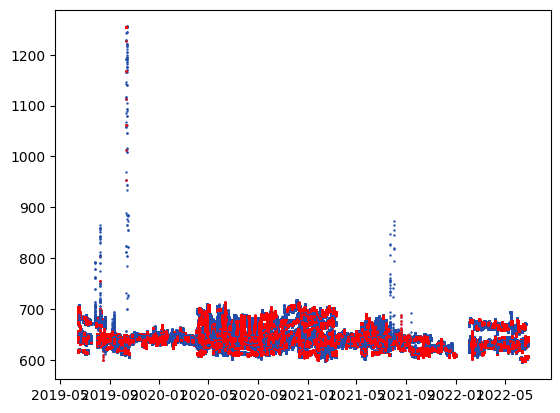

In [44]:
metrics_list = []
#iterate through each site
for site_id in site_names_list:
    print(f"Working on site: {site_id}")

    try:
        
        site_df[["datetime","pressure_hobo"]] = all_pressure_df[["datetime",site_id]]
        site_df['datetime'] = pd.to_datetime(site_df['datetime'], format='%Y-%m-%d %H:%M:%S')
        site_df = site_df[site_df['pressure_hobo'].notna()]
        all_days = pd.date_range(site_df['datetime'].min(), site_df['datetime'].max(), freq='15min')
        all_days = pd.DataFrame(all_days, columns=["datetime"])
        site_df = all_days.merge(site_df, on='datetime', how='left')

        #generating a test dataframe from our actual data. This function generate randomly indexed sequences of nas of random lengths
        test_df = get_test_df(site_df)

        #iterate through different potential down sample values
        for down_sample_value in down_sample_list:

            sparse_joined_test_df = down_sample_and_interpolate_once(test_df,all_days,down_sample_value,'pressure_hobo')
            
            #iterate through different potential moving average window widths
            for width_value in mv_avg_width_list:
                filled_test_df = sparse_joined_test_df
                filled_test_df["pressure_combined_filled"] = filled_test_df["pressure_combined"].rolling(min_periods=1, center=True, window=width_value).mean()

                my_nse = he.evaluator(he.nse, filled_test_df["pressure_combined_filled"], filled_test_df["pressure_hobo"])
                my_pbias = he.evaluator(he.pbias, filled_test_df["pressure_combined_filled"], filled_test_df["pressure_hobo"])
                my_rmse = he.evaluator(he.rmse, filled_test_df["pressure_combined_filled"], filled_test_df["pressure_hobo"])
                
                #add metrics and identifiers to a list of dictionaries
                metrics_dict = (site_id,down_sample_value, width_value, my_nse, my_pbias, my_rmse)
                metrics_list.append(metrics_dict)

    except:
        print(f"Site: {site_id} did not work")

#transform metrics list into dataframe
metrics_df = pd.DataFrame(metrics_list, columns=["site","down_sampled_to", "mv_avg_width","nse","pbias","rmse"])
metrics_df

(array([[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]]),
 array([-0.0163221 , -0.00357505,  0.00917199,  0.02191903,  0.03466607,
         0.04741312,  0.06016016,  0.0729072 ,  0.08565425,  0.09840129,
         0.11114833]),
 <a list of 1650 BarContainer objects>)

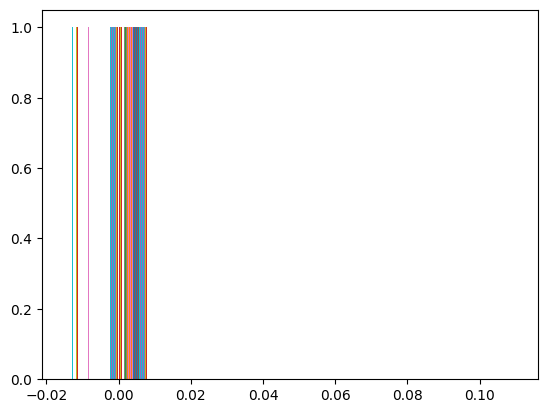

In [54]:
#metrics_df

plt.hist(x=metrics_df["pbias"])